In [7]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import yfinance as yf
from matplotlib.collections import PolyCollection
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import pmdarima as pmd
plt.rcParams['figure.figsize']=(10,8)

# Exploration des données (MASI)

In [8]:
MASI=pd.read_excel('HistoricDatas.xlsx',index_col=5,parse_dates=[5])
MASI['Prix']=MASI['Prix'].astype(str).str.replace(",", ".")
MASI['Prix']=MASI['Prix'].astype(str).str.replace(" ", "")
MASI['Prix']=MASI['Prix'].astype(float)

In [9]:
MASI

,Code,Codification,ExchangeCode,Libelle,Devise,Ouverture,Plus haut,Plus bas,Prix
Date,,,,,,,,,
2016-04-01,MA0000000050,ISIN,XCAS,MASI,MAD,"8 918,89","8 931,24","8 868,95",8888.04
2016-05-01,MA0000000050,ISIN,XCAS,MASI,MAD,"8 882,22","8 889,92","8 823,19",8837.81
2016-06-01,MA0000000050,ISIN,XCAS,MASI,MAD,"8 834,07","8 847,21","8 817,81",8842.12
2016-07-01,MA0000000050,ISIN,XCAS,MASI,MAD,"8 841,51","8 856,69","8 823,62",8856.09
2016-08-01,MA0000000050,ISIN,XCAS,MASI,MAD,"8 836,69","8 843,64","8 820,90",8836.93
...,...,...,...,...,...,...,...,...,...
2021-09-27,MA0000000050,ISIN,XCAS,MASI,MAD,"13 131,88","13 168,00","13 073,01",13122.02
2021-09-28,MA0000000050,ISIN,XCAS,MASI,MAD,"13 122,02","13 169,39","13 092,35",13169.39
2021-09-29,MA0000000050,ISIN,XCAS,MASI,MAD,"13 169,39","13 209,65","13 169,34",13197.28


In [10]:
Close=MASI['Prix']

## Evolution du cours de fermeture du MASI

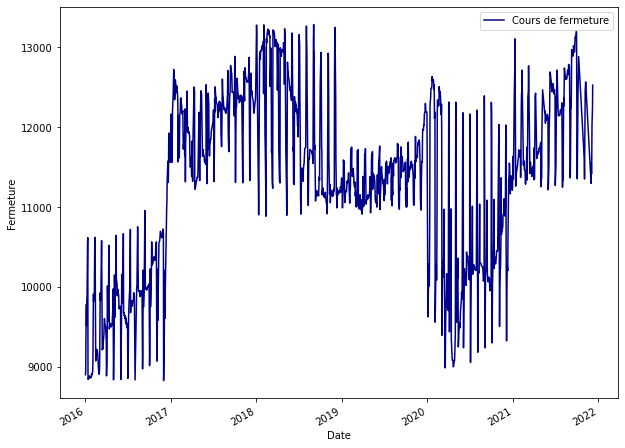

In [11]:
Close.plot(color='darkblue', label='Cours de fermeture', ylabel="Fermeture", xlabel="Date")
plt.legend(loc=1)

## Log-rendement du MASI 

On note $V_t$ le cours de fermeture du MASI à l'instant $t$. Le rendement simple entre $t$ et $t+1$ est alors $$R_{t|t+1}=\frac{V_{t+1}-V_{t}}{V_{t}}$$ 
Le log rendement est donné par $$r_{t|t+1}=ln(1+R_{t|t+1})$$

In [12]:
logreturn=np.log(1+Close.pct_change()).dropna()
logreturn 

Date
2016-05-01   -0.005667
2016-06-01    0.000488
2016-07-01    0.001579
2016-08-01   -0.002166
2016-12-01   -0.000908
                ...   
2021-09-27   -0.000751
2021-09-28    0.003603
2021-09-29    0.002116
2021-09-30   -0.000793
2021-01-10   -0.006170
Name: Prix, Length: 1429, dtype: float64

### Evolution des log-rendements

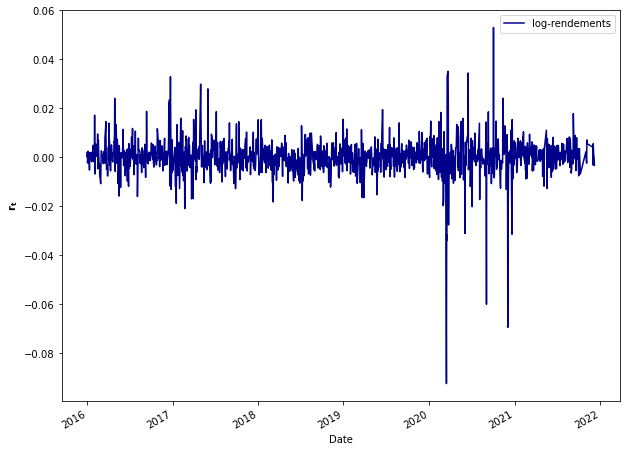

In [13]:
logreturn.plot(color='darkblue',label='log-rendements',ylabel=r'$\mathbf{r_{t}}$',xlabel='Date')
plt.legend(loc=1)

### Analyse descriptive des données

In [14]:
logreturn.describe()

count    1429.000000
mean        0.000272
std         0.007400
min        -0.092317
25%        -0.002757
50%         0.000284
75%         0.003453
max         0.053054
Name: Prix, dtype: float64

#### Coefficient d'asymétrie

La distribution des log-rendements est plus étalée à gauche

In [15]:
stats.skew(logreturn)

-1.8567405465205074

#### Coefficient d'applatissement

La distribution des log-rendements est leptokurtique

In [16]:
stats.kurtosis(logreturn)

29.28924284721211

In [17]:
stats.kurtosis(logreturn)-3

26.28924284721211

### Normalité des log-rendements

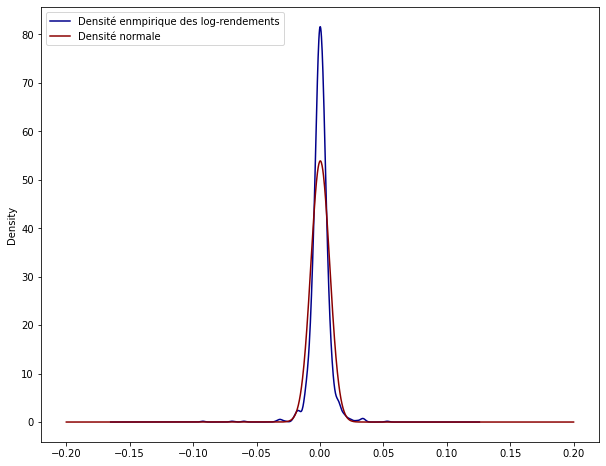

In [18]:
logreturn.plot(kind="kde", color="darkblue", label="Densité enmpirique des log-rendements")
x = np.linspace(-0.2, 0.2, len(logreturn))
plt.plot(x, stats.norm.pdf(x, logreturn.mean(), logreturn.std()), color='darkred', label="Densité normale")
plt.legend(loc=2)

(-5.0, 5.0)

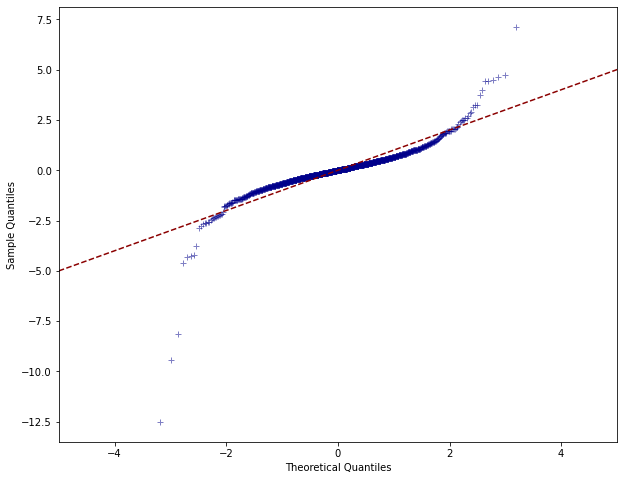

In [19]:
prob = sm.ProbPlot(logreturn, fit=True)
qq = prob.qqplot(marker='+', color='darkblue', alpha=0.5)
sm.qqline(qq.axes[0], line='45', color='darkred', linestyle='dashed')
plt.xlim((-5,5))

La distribution des log rendement n'est apparement pas normale. Les tests d'hypothèse ci après (Shapiro-Wilk, Jarque-Bera, Kolmogorov-Smirnov) confirment ce constat. 

In [20]:
stats.shapiro(logreturn)

ShapiroResult(statistic=0.8111395835876465, pvalue=6.035626222430837e-38)

In [21]:
stats.jarque_bera(logreturn)

Jarque_beraResult(statistic=51899.47519630094, pvalue=0.0)

In [22]:
stats.kstest(logreturn, 'norm')

KstestResult(statistic=0.48606175874913, pvalue=1.6763719853466e-311)

### Test de stationnarité

On teste la stationnarité (au sens large) de la série des log-rendements. Pour ce faire, on utilise le test de Dickey-Fuller augmenté(ADF).

Soit $(r_t)_{t\in \mathbb{N}}$ une série temporelle, Les trois modèles utilisés pour développer le test ADF sont les suivants:

Modèle 3: $\Delta r_t =\alpha +\beta t+ \phi r_{t-1} +\sum_{i=1}^{p}\phi_i \Delta r_{t-i} + e_t$, On teste $\alpha=0, \beta=0, \phi=0$

Modèle 2: $\Delta r_t =\alpha + \phi r_{t-1} +\sum_{i=1}^{p}\phi_i \Delta r_{t-i} + e_t$, On teste $\alpha=0, \phi=0$

Modèle 1: $\Delta r_t =\phi r_{t-1} +\sum_{i=1}^{p}\phi_i \Delta r_{t-i} + e_t$, On teste $\phi=0$


In [23]:
from arch.unitroot import ADF
#Constant and Linear Time Trend
adf1=ADF(logreturn,method='aic', trend='ct')
print(adf1,'\n')
#Constant
adf2=ADF(logreturn,method='aic', trend='c')
print(adf2,'\n')
#No Trend
adf3=ADF(logreturn,method='aic', trend='n')
print(adf3,'\n')

   Augmented Dickey-Fuller Results   
Test Statistic                -11.386
P-value                         0.000
Lags                                8
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.97 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

   Augmented Dickey-Fuller Results   
Test Statistic                -11.381
P-value                         0.000
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

   Augmented Dickey-Fuller Results   
Test Statistic                 -9.164
P-value                         0.000
Lags                               12
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), 

D'après le test ADF la série des log-rendements est stationnaire au sens large au seuil de 5%

### ACF/PACF

Soit $(r_t)_{t\in \mathbb{N}}$ une série temporelle, la fonction d'autocorrelation est définie comme suit 

$\rho: \mathbb{N} \rightarrow [-1,1]$

$k\mapsto Corr(r_t,r_{t+k})$

En considérant $(r_t)_{1,2\dots,T}$, l'estimation de la fonction d'autoccorélation est: $\forall k \in (1,\dots,T)$
$$\hat \rho(k) =\frac{\frac{1}{T-k} \sum_{t=1}^{T-k}(r_t-\bar r_T)(r_{t-k}-\bar r_T)}{\frac{1}{T}\sum_{t=1}^{T}(r_t-\bar r_T)^2}$$

Text(0.5, 1.0, 'PACF')

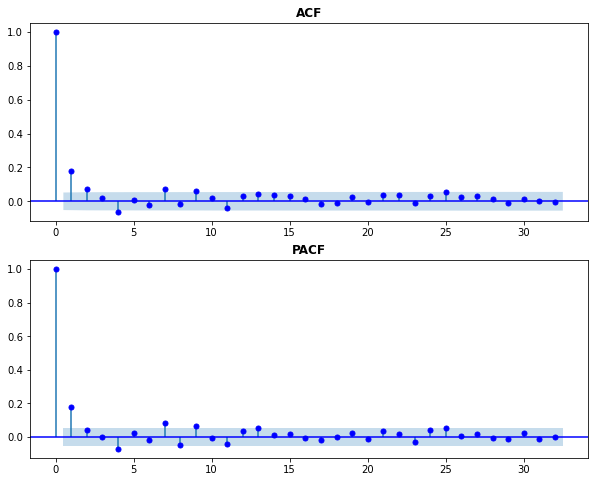

In [24]:
fig, ax = plt.subplots(2)
smt.graphics.plot_acf(logreturn, ax=ax[0], color='blue')
smt.graphics.plot_pacf(logreturn, ax=ax[1], color='blue')
ax[0].set_title('ACF',fontdict={'weight':'bold'})
ax[1].set_title('PACF',fontdict={'weight':'bold'})

### Test de ljung-Box

Soit $(e_t)_{t \in \{1,\dots,T\}} $, le test de ljung-Box teste les hypothèses suivantes:
$$(H_0): \rho(1)=\dots=\rho(k)=0$$
$$(H_1): \exists i \in (1,\dots,k): \rho(i)\neq 0$$
La statistique du test est 
$$Q(k)=T(T+2)\sum_{i=1}^{k}\frac{\hat \rho^2_i}{T-i}$$
Asymptotiquement, et sous $H_0$: 
$$Q(k) \sim \chi_k^2$$

In [25]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lj=acorr_ljungbox(logreturn,lags=8,return_df=True)
lj

,lb_stat,lb_pvalue
1,46.050036,1.152710e-11
2,54.118003,1.771842e-12
3,54.649344,8.156761e-12
4,59.992944,2.910784e-12
5,60.025260,1.200935e-11
6,60.649797,3.320899e-11
7,67.985463,3.768630e-12
8,68.276145,1.082131e-11


Le test affirme que la série des log de rendements n'est pas la réalisation d'un bruit blanc

# Modélisation de la série des log rendements à l'aide des modèles ARIMA, GARCH

### Modèles linéaires ARIMA

un processus $(r_t)_{t}$ est un processus ARIMA(p,d,q), s'il vérifie la relation suivante
$$(\mathbb{1}-B)^dr_t=\sum_{i=1}^{p}\phi_i r_{t-i} + e_t+\sum_{i=1}^{q}\theta_i e_{t-i}$$
avec $\phi_p$ et $\theta_q$ sont non nuls, et les racines des polynomes AR et MA sont de module strictement supérieur à 1

In [26]:
meanmdl=pmd.auto_arima(logreturn)

In [27]:
meanmdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1429
Model:               SARIMAX(2, 0, 0)   Log Likelihood                5008.034
Date:                Wed, 20 Oct 2021   AIC                         -10010.068
Time:                        21:36:54   BIC                          -9994.274
Sample:                             0   HQIC                        -10004.170
                               - 1429                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1725      0.010     16.788      0.000       0.152       0.193
ar.L2          0.0452      0.007      6.501      0.000       0.032       0.059
sigma2       5.29e-05   5.18e-07    102.183      0.000    5.19e-05    5.39e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             52596.33
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.32   Skew:                            -1.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

On retient le modèle AR(2) pour modéliser la partie esperance série des log rendements (mean model)

### Analyse des résidus

In [28]:
residuals=pd.Series(meanmdl.resid(),index=logreturn.index)

#### ACF/PACF

Text(0.5, 1.0, 'PACF')

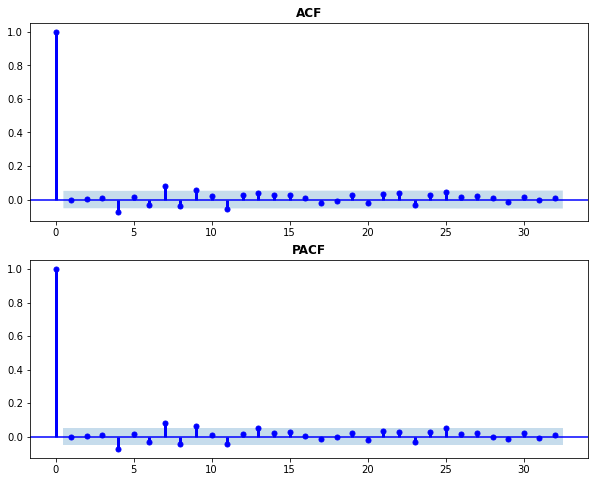

In [29]:
fig, ax = plt.subplots(2)
smt.graphics.plot_acf(residuals, ax=ax[0], color='blue',vlines_kwargs={'linewidth':3,'color':'blue'})
smt.graphics.plot_pacf(residuals, ax=ax[1], color='blue', vlines_kwargs={'linewidth':3,'color':'blue'})
ax[0].set_title('ACF',fontdict={'weight':'bold'})
ax[1].set_title('PACF',fontdict={'weight':'bold'})

#### Test de ljung-Box

In [30]:
acorr_ljungbox(residuals, lags=6, return_df=True)

,lb_stat,lb_pvalue
1,0.001315,0.971075
2,0.009402,0.995310
3,0.139849,0.986660
4,7.551740,0.109449
5,7.866383,0.163755
6,9.316162,0.156562


Les résidus du mean model sont les réalisations d'un bruit blanc

Le carré des résidus montrent une $Serial$ $dependence$

Text(0.5, 1.0, 'PACF')

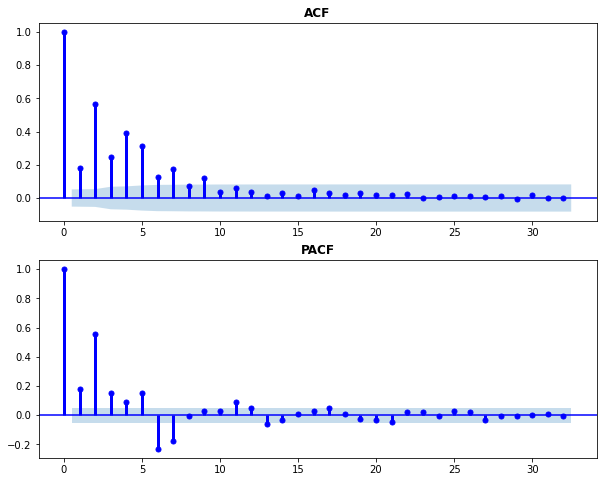

In [31]:
fig, ax = plt.subplots(2)
smt.graphics.plot_acf(residuals**2, ax=ax[0], color='blue',vlines_kwargs={'linewidth':3,'color':'blue'})
smt.graphics.plot_pacf(residuals**2, ax=ax[1], color='blue', vlines_kwargs={'linewidth':3,'color':'blue'})
ax[0].set_title('ACF',fontdict={'weight':'bold'})
ax[1].set_title('PACF',fontdict={'weight':'bold'})

### Modèles GARCH

Un processus $(e_t)$ est une processus GARCH(p,q) fort s'il s'écrit de la manière suivante

$$e_t=\eta_t \sigma_t$$

$$\sigma_t^2=\omega+\sum_{i=1}^{p}\alpha_i e_{t-i}^2+\sum_{i=1}^{q}\beta_i \sigma_{t-i}^2$$

avec $\omega>0$ et $\alpha_i,\beta_i>0$

$(\eta_t)_t$ est une bruit blanc fort (0,1)

$\sigma_t^2=Var(e_t\ | \ \mathcal{F}_{t-1})$, $(\mathcal{F}_{t})_t$ est la filtration canonique associée au processus $(e_t)_t$

#### Test des effets ARCH

Soit $(e_t)_{t\in (1,\dots,T)}$ qu'on suppose un ARCH(p). Le test des effets Arch teste
$$(H_0): \alpha_1=\dots=\alpha_p=0$$
La statistique du test suit asymptotiquement, sous $H_0$ la loi $\chi_p^2$

In [32]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.diagnostic import het_arch
test_arch=het_arch(residuals)
name=["LM-stat","LM p-value", "F-stat", "F p-value"]
pd.DataFrame(test_arch, index=name)

,0
LM-stat,6.021164e+02
LM p-value,8.554640e-112
F-stat,4.312168e+01
F p-value,8.759458e-149


D'après ce test il y a présence des effets ARCH dans les résidus du modèle AR(2) (au seuil de 5%)

#### Test de kolmogorov-Smirnov

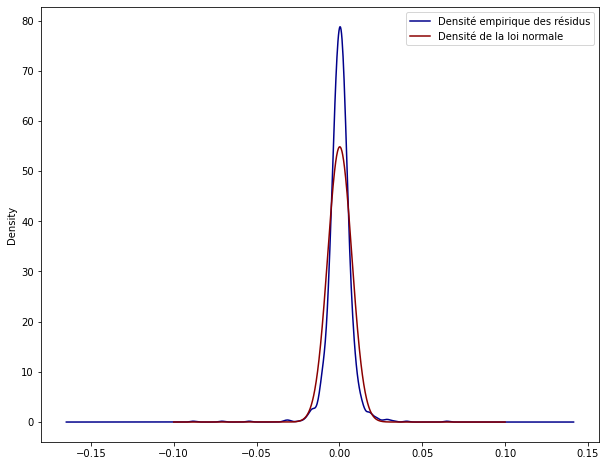

In [33]:
residuals.plot(kind="kde",color='darkblue',label='Densité empirique des résidus')
x=np.linspace(-0.1,0.1,len(residuals))
plt.plot(x,stats.norm.pdf(x,residuals.mean(),residuals.std()),color="darkred",label="Densité de la loi normale")
plt.legend()

Clairement la distribution des résidus du modèle n'est pas normale. on teste alors si la distribution des résidus est student. Pour se faire, on utilise le test de Kolmogorov-Smirnov.

D'après le test la distribution des résidus est (au seuil de 5%) de loi de student à 3 degrés de liberté.

In [34]:
p = stats.t.fit(residuals)
p1=stats.norm.fit(residuals)
stats.kstest(residuals, 't', args=p), stats.kstest(residuals, 'norm', args=p1)

(KstestResult(statistic=0.011878248817145942, pvalue=0.9863376994615067),
 KstestResult(statistic=0.09553311303132739, pvalue=8.393549462798728e-12))

In [35]:
p

(3.0769248202830415, 0.0002590106240349931, 0.004161542657667553)

#### Modélisation des résidus à l'aide de modèle de GRACH

In [36]:
from arch.univariate import arch_model
varmodel=arch_model(residuals, mean = 'Zero', vol="GARCH", rescale=True, dist='studentst').fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 22644.439874161304
Iteration:      2,   Func. Count:     13,   Neg. LLF: 2688.2590168201823
Iteration:      3,   Func. Count:     19,   Neg. LLF: 2538.5911187313854
Iteration:      4,   Func. Count:     26,   Neg. LLF: 2458.7889217251613
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2570.4325209905346
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1183.6058908426946
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1182.975389159828
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1182.97456486201
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1182.974524781647
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1182.974524781671
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1182.974524781647
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10


In [37]:
varmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Zero Mean - GARCH Model Results                           
====================================================================================
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -1182.97
Distribution:      Standardized Student's t   AIC:                           2373.95
Method:                  Maximum Likelihood   BIC:                           2395.01
                                              No. Observations:                 1429
Date:                      Wed, Oct 20 2021   Df Residuals:                     1429
Time:                              21:37:23   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0482  2.112e-02      2.281  2.254e-02 [6.782e-03,8.956e-02]
alpha[1]       0.1936  6.412e-02      3.019  2.534e-03   [6.793e-02,  0.319]
beta[1]        0.6911      0.104      6.633  3.287e-11     [  0.487,  0.895]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.9354      0.579      8.522  1.562e-17 [  3.800,  6.070]
========================================================================

Covariance estimator: robust
"""

On remarque que $\omega$>0, $\alpha_1$>0, $\beta_1$>0 et que $\alpha_1+\beta_1$<1 donc la condition de stationnarité au second ordre est vérifiée

On vérifie maintenant la condition concernant $(\eta_t)$ qui stipule qu'il s'agit d'un bruit blanc fort

$$\hat \eta_t=\frac{\hat e_t}{\hat \sigma_t}$$

In [38]:
eta = varmodel.resid/varmodel.conditional_volatility

Text(0.5, 1.0, 'PACF')

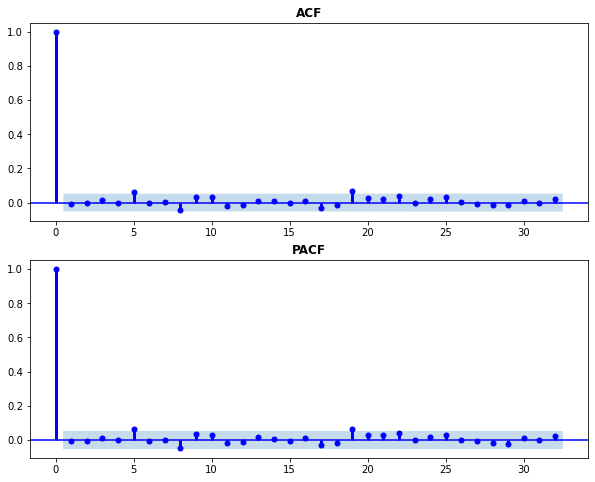

In [39]:
fig, ax = plt.subplots(2)
smt.graphics.plot_acf(eta, ax=ax[0], color='blue',vlines_kwargs={'linewidth':3,'color':'blue'})
smt.graphics.plot_pacf(eta, ax=ax[1], color='blue', vlines_kwargs={'linewidth':3,'color':'blue'})
ax[0].set_title('ACF',fontdict={'weight':'bold'})
ax[1].set_title('PACF',fontdict={'weight':'bold'})

In [40]:
sm.stats.diagnostic.acorr_ljungbox(eta, lags=5, return_df=True)

,lb_stat,lb_pvalue
1,0.087382,0.767532
2,0.125504,0.939177
3,0.384770,0.943370
4,0.385271,0.983665
5,5.815111,0.324627


$(\eta_t)$ s'agit bien (au seuil de 5%) d'un bruit blanc faible. On teste maintenant la présence des effets ARCH  

In [41]:
tarch=het_arch(eta)
name=["LM","LM p-value", "F", "F p-value"]
pd.Series(tarch, index=name)

LM            22.272161
LM p-value     0.563026
F              0.926176
F p-value      0.565758
dtype: float64

On conclue (au seuil de 5%) que $(\eta_t)$ est un bruit blanc fort

On retient le modèle AR(2) pour $E(r_{t+1} | \mathcal{F}_t)$ et le modèle GARCH(1,1) pour $Var(r_{t+1} | \mathcal{F}_t)$

On vérifie maintenant si AR(2)-GARCH(1,1) est le modèle de la série des log rendements

In [42]:
from rpy2.robjects.packages import importr, data
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
from rpy2.robjects.vectors import FloatVector
import rpy2.robjects.numpy2ri as rpyn
base = importr('base')
rugarch = importr('rugarch')

In [43]:
VModel = rugarch.ugarchspec(mean_model = ro.r('list(armaOrder=c(2,0), include.mean=F)'), variance_model = ro.r('list(model="sGARCH", garchOrder=c(1,1))'), distribution_model='std')
Ldata = FloatVector(logreturn.values)
VModel_fit = rugarch.ugarchfit(spec=VModel, data=Ldata)

In [44]:
base.print(VModel_fit)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(2,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
ar1     0.090452    0.028490  3.17491 0.001499
ar2     0.012804    0.026717  0.47925 0.631757
omega   0.000005    0.000001  7.81707 0.000000
alpha1  0.189465    0.026300  7.20399 0.000000
beta1   0.699436    0.028705 24.36623 0.000000
shape   4.494794    0.462856  9.71100 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
ar1     0.090452    0.030853  2.93173 0.003371
ar2     0.012804    0.026177  0.48914 0.624741
omega   0.000005    0.000001  5.30695 0.000000
alpha1  0.189465    0.025043  7.56553 0.000000
beta1   0.699436    0.042971 16.27691 0.000000
shape   4.494794    0.556562  8.07599 0.000000

LogLikel

<rpy2.robjects.methods.RS4 object at 0x0000021C631B3300> [RTYPES.S4SXP]
R classes: ('uGARCHfit',)

Le coefficient associé au AR(2) est significativement nul (au seuil de 5%). On retient donc le modèle AR(1)-GARCH(1,1) pour modéliser la série des log rendements

In [45]:
VModelf = rugarch.ugarchspec(mean_model = ro.r('list(armaOrder=c(1,0), include.mean=F)'), variance_model = ro.r('list(model="sGARCH", garchOrder=c(1,1))'), distribution_model='std')
Ldata = FloatVector(logreturn.values)
VModelf_fit = rugarch.ugarchfit(spec=VModelf, data=Ldata)

In [46]:
base.print(VModelf_fit)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
ar1     0.091051    0.028439   3.2016 0.001367
omega   0.000005    0.000001   7.5540 0.000000
alpha1  0.187165    0.025950   7.2126 0.000000
beta1   0.702794    0.028390  24.7551 0.000000
shape   4.496159    0.461721   9.7378 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
ar1     0.091051    0.031533   2.8875 0.003883
omega   0.000005    0.000001   5.0766 0.000000
alpha1  0.187165    0.024622   7.6017 0.000000
beta1   0.702794    0.042834  16.4072 0.000000
shape   4.496159    0.550611   8.1658 0.000000

LogLikelihood : 5401.991 

Information Criteria
------------------------------------
                 

<rpy2.robjects.methods.RS4 object at 0x0000021C65B59F40> [RTYPES.S4SXP]
R classes: ('uGARCHfit',)

# Value at Risk

On se place dans un espace probabilisé $(\Omega,\mathcal{F},\mathbb{P})$.

#### Variable aléatoire de perte

Soit $V_t$ la valeur à l'instant $t$ d'un portefeuille (ici l'indice), le processus $(V_t)_{t\in \mathbb{N}}$ est adapté. La variable aléatoire perte entre $t$ et $t+1$ s'écrit comme suit:
$$L_{t|t+1}=-(V_{t+1}-V_t)$$

Dans la pratique $V_t$ est modélisé comme une fonction de temps et d'un vecteur aléatoire $Z_t=(Z_{t,1},\dots,Z_{t,d})'$ des facteurs de risque, $Z_t$ est supposé mesurable. Donc $$V_t=f(t,Z_t)$$ 
Avec $f:\mathbb{R}_+ \times \mathbb{R}^d \rightarrow \mathbb{R}$ une fonction mesurable.

La série des variations des facteurs de risque est définie comme suit:
$$X_t=Z_t-Z_{t-1}$$

#### Définitions de la VaR

Soit un niveau de confiance $\alpha \in ]0,1[$. La VaR du portefeuille pour le niveau de confiance $\alpha$ est donnée par
$$VaR_{\alpha}=inf\{l\in \mathbb{R}: \mathbb{P}(L>l)\leq 1-\alpha\}=inf\{l\in \mathbb{R}: F_L(l)\geq \alpha\}$$

#### Calcul de la VaR
$\bullet$ Méthode de Variance-Covariance

On suppose que la v.a perte s'écrit comme suit:

$$L_{t+1}=-(a_t+b_t' X_{t+1})$$

Avec $a_t$ une constante connue à $t$, et $b_t$ un vecteur de $\mathbb{R}^d$ lui aussi connue à $t$.

On suppose que $X_{t+1}  | \mathcal{F}^X_t\sim \mathcal{N}_d(\mu_{t+1}, \Sigma_{t+1})$, et on a donc

$$L_{t+1} | \mathcal{F}^X_t \sim \mathcal{N}(-a_t-b_t' \mu_{t+1}, b_t'\Sigma_{t+1} b_t)$$

La VaR calculée avec cette méthode est conditionnelle et se note par $VaR_{\alpha}^{t+1|t}$

- De VaR(L) à VaR(r)

On a $L_{t+1}=V_t-V_{t+1}=\frac{R_{t+1|t}}{V_t}$ et $r_{t+1|t}=ln(1+R_{t+1|t})$, donc 

$$\mathbb{P}(L_{t+1}\leq VaR_{\alpha}^{t+1|t}(L)|\mathcal{F}_t)=\alpha \iff \mathbb{P}(R_{t+1|t}\geq -\frac{VaR_{\alpha}^{t+1|t}(L)}{V_t}|\mathcal{F}_t)=\alpha$$

$$\iff \mathbb{P}(r_{t+1|t}\geq ln(1-\frac{VaR_{\alpha}^{t+1|t}(L)}{V_t}|\mathcal{F}_t)=\alpha$$

D'où,$VaR_{\alpha}^{t+1|t}(L)=-V_t$ $VaR_{1-\alpha}^{t+1|t}(R)= V_t(1-exp(VaR_{1-\alpha}^{t+1|t}(r))$

La VaR conditionnelle est donnée par:
$$VaR_{\alpha}^{t+1|t}(r)= E(r_{t+1} | \mathcal{F}_t) + Var(r_{t+1} | \mathcal{F}_t) q_{\alpha}$$

$q_{\alpha}$ est le quantile d'ordre $\alpha$ de la loi conditionnelle de $r_{t+1}$

## Estimation et prévision de la VaR par Rolling Window

On dispose de 1429 observations de la série $(r_t)$, on divise cet échantillon en deux partie, une pour l'estimation des paramètres at une autre pour le test. 

La première est composée de 1129 observations, la deuxième de 300.

In [55]:
str(logreturn.index[1129])

'2020-07-15 00:00:00'

### Calcul de la VaR par le modèle AR(1)-GARCH(1,1)

In [57]:
argarch_forecast = rugarch.ugarchroll(spec= VModelf, n_ahead = 1, n_start=1129, refit_every=1, refit_window = 'moving', data=Ldata)

In [71]:
#de R à Python
with localconverter(ro.default_converter + pandas2ri.converter):
  out = ro.conversion.rpy2py(argarch_forecast.slots['forecast'][1])

In [72]:
out.index=logreturn.loc['2020-07-15':].index

In [73]:
out

,Mu,Sigma,Skew,Shape,Shape(GIG),Realized
Date,,,,,,
2020-07-15,-0.000177,0.005106,0.0,4.758049,0.0,0.009950
2020-07-16,0.001047,0.006863,0.0,4.733710,0.0,0.001902
2020-07-17,0.000200,0.006024,0.0,4.731620,0.0,-0.000034
2020-07-20,-0.000004,0.005407,0.0,4.724218,0.0,-0.000949
2020-07-21,-0.000100,0.004987,0.0,4.713954,0.0,-0.003288
...,...,...,...,...,...,...
2021-09-27,0.000288,0.005742,0.0,4.431407,0.0,-0.000751
2021-09-28,-0.000052,0.005430,0.0,4.425975,0.0,0.003603
2021-09-29,0.000250,0.005332,0.0,4.447806,0.0,0.002116


In [74]:
q=[]
for i in range(out.shape[0]):
    q.append(rugarch.qdist(distribution='std', p=0.05, shape=FloatVector(out['Shape'])))

In [75]:
VaR_argarch = pd.Series(out['Mu'].values + out['Sigma'].values*np.array(q[0]), index=out.index)
VaR_argarch

Date
2020-07-15   -0.008099
2020-07-16   -0.009594
2020-07-17   -0.009140
2020-07-20   -0.008385
2020-07-21   -0.007827
                ...   
2021-09-27   -0.008531
2021-09-28   -0.008391
2021-09-29   -0.007944
2021-09-30   -0.007737
2021-01-10   -0.007655
Length: 300, dtype: float64

In [85]:
bargarch=pd.concat([logreturn.loc['2020-07-15':],VaR_argarch],axis=1)
bargarch.columns = ['logreturn', 'VaR_argarch']
bargarch

,logreturn,VaR_argarch
Date,,
2020-07-15,0.009950,-0.008099
2020-07-16,0.001902,-0.009594
2020-07-17,-0.000034,-0.009140
2020-07-20,-0.000949,-0.008385
2020-07-21,-0.003288,-0.007827
...,...,...
2021-09-27,-0.000751,-0.008531
2021-09-28,0.003603,-0.008391
2021-09-29,0.002116,-0.007944


On a un $dépacement$ lorsque: $r_{t+1}\leq \widehat{VaR}_{\alpha}^{t+1|t}$

In [87]:
dep_argarch=bargarch[bargarch['logreturn']<=bargarch['VaR_argarch']]['logreturn']

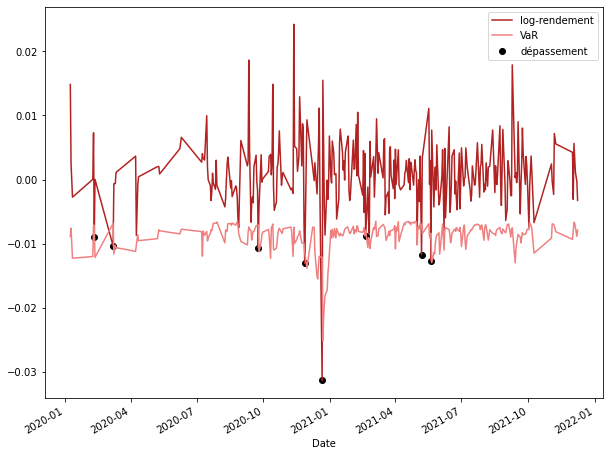

In [101]:
bargarch['logreturn'].plot(color='firebrick',label='log-rendement')
bargarch['VaR_argarch'].plot(color='lightcoral',label='VaR')
plt.scatter(dep_argarch.index, dep_argarch.values, color='black',label='dépassement')
plt.legend()

#### Ratio de dépassement

$$Rd=\frac{1}{T-W}\sum_{t=W+1}^{T}\mathbb{1}_{\{r_{t}\leq VaR_{\alpha}^{t|t-1}\}}$$

$W$ la taille de la fenêtre

In [105]:
Rd_argarch=len(dep_argarch)/300
Rd_argarch

0.02666666666666667